In [8]:
from datasets.memmap_dataset import MemMapSpatioTemporalDataset
from models.spatiotemporal_model import SpatioTemporalModel
from models.base import BaseModel
from tqdm.auto import tqdm
import torch
import os

# Training
train_path = "/mounts/Datasets3/2022-ChallengePlankton/sub_2CMEMS-MEDSEA-2010-2016-training.nc.bin"
test_path = "/mounts/Datasets3/2022-ChallengePlankton/sub_2CMEMS-MEDSEA-2017-testing.nc.bin"
use_cuda = torch.cuda.is_available()
batch_size = 128
num_workers = 8

# Experiment

num_cnn_layers = 3
num_lstm_layers = 2
num_fc_layers = 4
hidden_size = 128

# defines the dimensions of the neighborhood
# a neghborhood of size 1 means that the axis is not considered.
# preferably, the neighborhood size should be odd
lat_neghborhood_size = 1
lon_neghborhood_size = 1
depth_neghborhood_size = 11

with_position_embedding = True

experiment_name = f"spatio_temporal_model_\
{num_cnn_layers}_\
{num_lstm_layers}_\
{num_fc_layers}_\
{hidden_size}_\
{lat_neghborhood_size}_\
{lon_neghborhood_size}_\
{depth_neghborhood_size}_\
{'with_position_embedding' if with_position_embedding else 'without_position_embedding'}"

ckpt = os.listdir(f"checkpoints/{experiment_name}")[-1]
ckpt = f"checkpoints/{experiment_name}/{ckpt}"
print("Submitting with checkpoint", ckpt)

/usr/users/sdi1/sdi1_29/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Submitting with checkpoint checkpoints/spatio_temporal_model_3_2_4_128_1_1_11_with_position_embedding/checkpoint-epoch=185-valid_srmsle=0.01180-train_srmsle=0.01028.ckpt


In [71]:
valid_dataset = MemMapSpatioTemporalDataset(
    bin_path=train_path,
    train=True,
    valid=True,
    valid_interval_length=365,
    lat_neghborhood_size=lat_neghborhood_size,
    lon_neghborhood_size=lon_neghborhood_size,
    depth_neghborhood_size=depth_neghborhood_size,
    overwrite_index=False,
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

test_dataset = MemMapSpatioTemporalDataset(
    bin_path=test_path,
    train=False,
    valid=False,
    lat_neghborhood_size=lat_neghborhood_size,
    lon_neghborhood_size=lon_neghborhood_size,
    depth_neghborhood_size=depth_neghborhood_size,
    overwrite_index=False,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

In [72]:
model = SpatioTemporalModel(
    features_size=valid_dataset.nfeatures,
    hidden_size=hidden_size,
    targets_size=valid_dataset.ntargets,

    num_cnn_layers=num_cnn_layers,
    num_lstm_layers=num_lstm_layers,
    num_fc_layers=num_fc_layers,

    lat_neghborhood_size=lat_neghborhood_size,
    lon_neghborhood_size=lon_neghborhood_size,
    depth_neghborhood_size=depth_neghborhood_size,

    with_position_embedding=with_position_embedding,
    lat_size=valid_dataset.nlatitudes,
    lon_size=valid_dataset.nlongitudes,
    depth_size=valid_dataset.ndepths,
).to('cuda' if use_cuda else 'cpu').eval()

model = BaseModel.load_from_checkpoint(
    model=model,
    checkpoint_path=ckpt
)

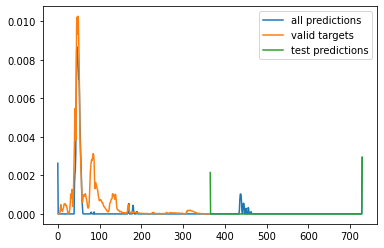

In [88]:
# plot the prediction vs the target
import matplotlib.pyplot as plt
import numpy as np

rand_idx = np.random.randint(0, len(valid_dataset))

position, valid_features, valid_targets = valid_dataset[rand_idx]
position, test_features = test_dataset[rand_idx]

all_features = torch.cat([valid_features, test_features], dim=-2)

all_predictions = model(
    position.unsqueeze(0).to('cuda' if use_cuda else 'cpu'),
    all_features.unsqueeze(0).to('cuda' if use_cuda else 'cpu')
)
test_predictions = model(
    position.unsqueeze(0).to('cuda' if use_cuda else 'cpu'),
    test_features.unsqueeze(0).to('cuda' if use_cuda else 'cpu')
)

plt.plot(range(730), all_predictions.cpu().detach().numpy().flatten(), label="all predictions")
plt.plot(range(365), valid_targets.cpu().detach().numpy().flatten(), label="valid targets")
plt.plot(range(365, 730), test_predictions.cpu().detach().numpy().flatten(), label="test predictions")
plt.legend()
plt.show()

In [12]:
# plot the error over the whole dataset
import numpy as np

predictions = []
targets = []
for position, features, target in tqdm(test_loader):
    position = position.to('cuda' if use_cuda else 'cpu')
    features = features.to('cuda' if use_cuda else 'cpu')
    target = target.to('cuda' if use_cuda else 'cpu')
    prediction = model(position, features)
    predictions.append(prediction.cpu().detach().numpy())
    targets.append(target.cpu().detach().numpy())
    
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

plt.plot((predictions - targets)**2, label="squared error")
plt.legend()

 86%|████████▋ | 153/177 [03:32<00:33,  1.39s/it]


KeyboardInterrupt: 